In [1]:
import tensorflow as tf
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)


2024-07-24 16:19:53.106643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 16:19:53.106791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 16:19:53.258781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
train_directory = "/kaggle/input/emotion-detection-fer/train"
val_directory = "/kaggle/input/emotion-detection-fer/test"

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 48,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.05,
    "REGULARIZATION_RATE": 0.001,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "disgusted","fearful","happy","neutral", "sad","surprised"]
}

In [4]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 28709 files belonging to 7 classes.


In [5]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 7178 files belonging to 7 classes.


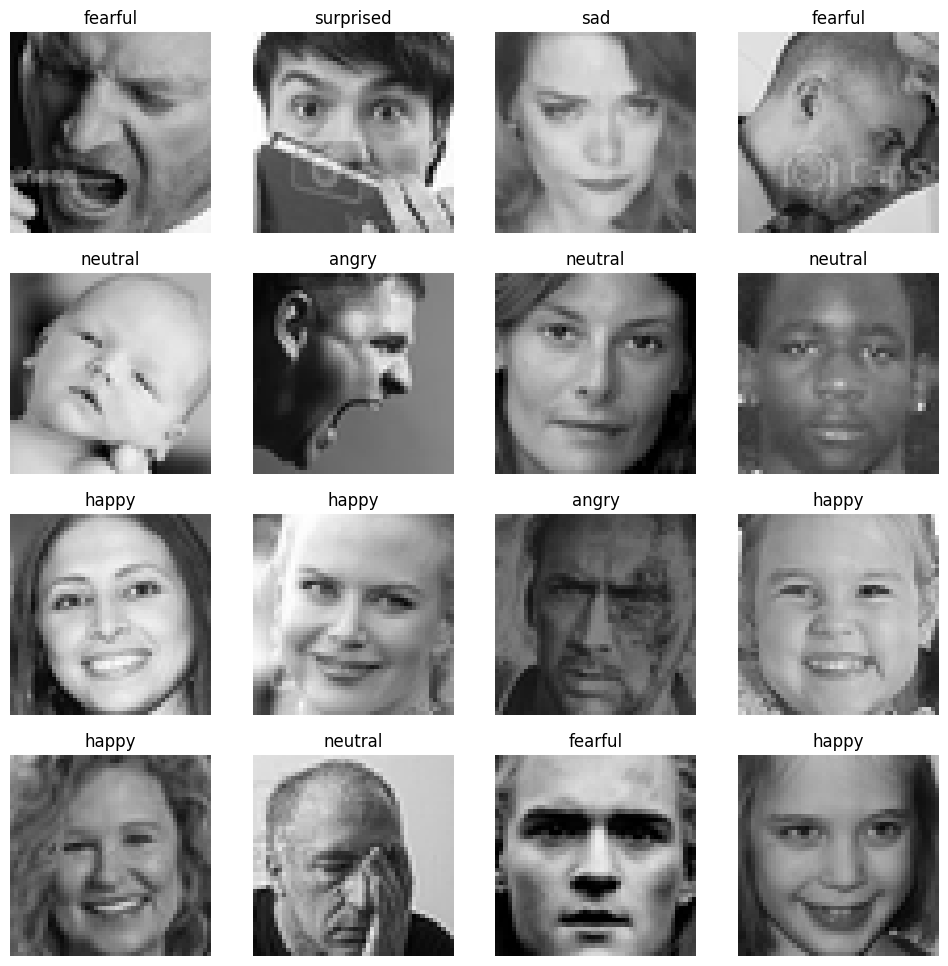

In [6]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [7]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)


In [8]:

validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),                 
])

In [10]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 46, 46, 6)      │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,777,271 (6.78 MB)

 Trainable params: 1,774,923 (6.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [11]:
loss_function = CategoricalCrossentropy()

In [12]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=4, name = "top_k_accuracy")]

In [13]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)
     

In [14]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  batch_size= CONFIGURATION["BATCH_SIZE"],

  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1
)

Epoch 1/20


2024-07-24 16:20:25.110274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.87913, expected 6.06884
2024-07-24 16:20:25.110335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.19596, expected 4.38567
2024-07-24 16:20:25.110346: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.9744, expected 5.16411
2024-07-24 16:20:25.110354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.50678, expected 5.69649
2024-07-24 16:20:25.110362: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 23: 6.80629, expected 5.996
2024-07-24 16:20:25.110370: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 25: 7.01874, expected 6.20845
2024-07-24 16:20:25.110378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.80312, expected 5.99282
2024-07-24 16:20:25.110385: E external/local_xla/xla/s

  9/898 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.1955 - loss: 4.2050 - top_k_accuracy: 0.5810

I0000 00:00:1721838029.959846      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3550 - loss: 3.0504 - top_k_accuracy: 0.7992

2024-07-24 16:21:17.239094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.62283, expected 4.88686
2024-07-24 16:21:17.239164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.16106, expected 5.42509
2024-07-24 16:21:17.239183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 39: 6.22402, expected 5.48805
2024-07-24 16:21:17.239195: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 40: 5.4288, expected 4.69283
2024-07-24 16:21:17.239206: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 6.06746, expected 5.33149
2024-07-24 16:21:17.239217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 76: 5.95051, expected 5.21454
2024-07-24 16:21:17.239227: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 96: 6.13109, expected 5.39512
2024-07-24 16:21:17.239238: E external/local_xla/xl

898/898 ━━━━━━━━━━━━━━━━━━━━ 74s 71ms/step - accuracy: 0.3551 - loss: 3.0494 - top_k_accuracy: 0.7993 - val_accuracy: 0.3578 - val_loss: 2.2217 - val_top_k_accuracy: 0.8417
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4440 - loss: 1.9635 - top_k_accuracy: 0.8802 - val_accuracy: 0.3688 - val_loss: 2.0812 - val_top_k_accuracy: 0.8373
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.4579 - loss: 1.8071 - top_k_accuracy: 0.8946 - val_accuracy: 0.4604 - val_loss: 1.8551 - val_top_k_accuracy: 0.8976
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4821 - loss: 1.8069 - top_k_accuracy: 0.9030 - val_accuracy: 0.4546 - val_loss: 1.8630 - val_top_k_accuracy: 0.9000
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5012 - loss: 1.7889 - top_k_accuracy: 0.9098 - val_accuracy: 0.4600 - val_loss: 1.8749 - val_top_k_accuracy: 0.8998
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5158 - loss: 1.7823 - t

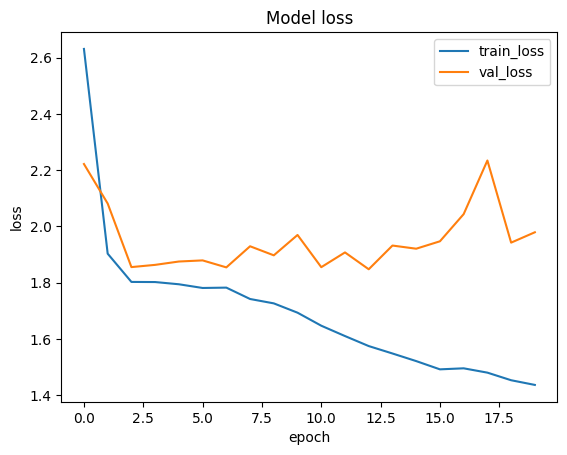

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

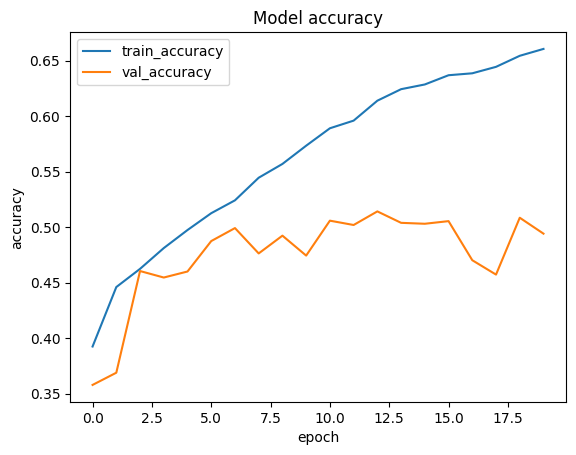

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [17]:
lenet_model.save('face_detection_model.h5')